In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/Shareddrives/My\ paper

/content/drive/Shareddrives/My paper


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('./Customer Value Prediction/TABLES/Handcrafted Features.csv')

In [ ]:
len(data)

83931

In [ ]:
Counter(data['VIP'])

Counter({0.0: 72733, 1.0: 11198})

In [ ]:
# all X columns
X_cols = ['Lifespan_days', 'CAI', 'Monetary', 'Recency', 'Frequency', 'ActiveDays', 'PromotionUsedRate', 'CompleteOrders', 'ReturnRate']

## Build Model

In [ ]:
X = data[X_cols]
y = data['VIP'].astype(int)

### Step 1: Undersampling major class Experiment 

In [ ]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 72733, 1: 11198})


In [ ]:
print('Total: ', len(data))
print('Not VIP %:', counter[0]/len(data))
print('VIP %:', counter[1]/len(data))

Total:  83931
Not VIP %: 0.8665808819149063
VIP %: 0.1334191180850937


In [ ]:
class ActivePrediction():
  def __init__(self, X, y, active_weight, X_cols):
    self.X = X
    self.y = y
    self.active_weight = active_weight
    self.X_cols = X_cols

    self.reset()

  def reset(self):
    self.data_res = []
    self.X_binary = []
    self.y_binary = []

    self.cv_score_accuracy = []
    self.cv_score_roc = []

    self.train_accuracy = 0
    self.test_accuracy = 0
    self.test_F1 = 0
    self.test_auc = 0

    self.classification_report = []

    self.y_test = []
    self.y_preds = []

  def undersampling(self):
    print('------------------- Start to undersampling-------------------------')
    counter = Counter(y)
    inactive_num = int(counter[1]*(1-self.active_weight)/self.active_weight)
    nm = NearMiss(sampling_strategy={0: inactive_num}, version=1)
    X_res, y_res = nm.fit_resample(self.X, self.y)

    # summarize the new class distribution
    counter = Counter(y_res)
    print('undersampling:', counter)
    print('------------------- Finished to undersampling-------------------------')
    return pd.concat([X_res, y_res], axis=1)
    

  def cross_val(self, score, X_train, y_train):
    rfc_cv_score = cross_val_score(self.model, X_train, y_train, cv=5, scoring=score)
    return {'scores': rfc_cv_score, 'Mean score': rfc_cv_score.mean()}

  def train_RF_model(self, X_train, X_test, y_train, y_test):
    self.model = RandomForestClassifier(max_depth=5,n_estimators=200)
    self.model.fit(X_train, y_train)
    self.y_pred = self.model.predict(X_test)
    print('------------------- Start to CV-------------------------')
    self.cv_score_accuracy = self.cross_val('accuracy', X_train, y_train)
    self.cv_score_roc = self.cross_val('roc_auc_ovr', X_train, y_train)
    print('------------------- Finished to CV-------------------------')

    print("Accuracy score on train data:", self.model.score(X_train, y_train))
    print("Accuracy score on test data:", self.model.score(X_test, y_test))
    
    self.train_accuracy = self.model.score(X_train, y_train)
    self.test_accuracy = self.model.score(X_test, y_test)

    self.test_F1 = f1_score(y_test, self.y_pred)
    self.test_auc = roc_auc_score(y_test, self.y_pred)
    print('F1 score on test data:', self.test_F1)
    print('AUC score on test data:', self.test_auc)
 
    labels = [0, 1]
    label_names = ['inactive', 'active']
    self.classification_report = classification_report(y_test, self.y_pred,labels=labels,target_names=label_names)

  def build_model(self):
    if self.active_weight == 0:
      self.data_res = pd.concat([self.X, self.y], axis=1)
      X_binary = self.X
      y_binary = self.y
    else:
      self.data_res = self.undersampling()
      X_binary = self.data_res[X_cols]
      y_binary = self.data_res['VIP'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=123)

    self.train_RF_model(X_train, X_test, y_train, y_test)
    self.y_test = y_test

In [ ]:
active_weights = [0.3, 0.4, 0.5]
models = []

for w in active_weights:
  print('Active_weight:', w)
  model = ActivePrediction(X, y, w, X_cols)
  model.build_model()

  models.append(model)

Active_weight: 0.3
------------------- Start to undersampling-------------------------
undersampling: Counter({0: 26128, 1: 11198})
------------------- Finished to undersampling-------------------------
------------------- Start to CV-------------------------
------------------- Finished to CV-------------------------
Accuracy score on train data: 0.9078365706630944
Accuracy score on test data: 0.9022234128047147
F1 score on test data: 0.8160282258064516
AUC score on test data: 0.8479121424153289
Active_weight: 0.4
------------------- Start to undersampling-------------------------
undersampling: Counter({0: 16797, 1: 11198})
------------------- Finished to undersampling-------------------------
------------------- Start to CV-------------------------
------------------- Finished to CV-------------------------
Accuracy score on train data: 0.9146276120735846
Accuracy score on test data: 0.9135559921414538
F1 score on test data: 0.8836538461538461
AUC score on test data: 0.8975551850687

In [ ]:
pd.DataFrame([models[0].cv_score_accuracy, models[1].cv_score_accuracy, models[2].cv_score_accuracy])

,scores,Mean score
0,"[0.9099129269926323, 0.9084058941728065, 0.903...",0.906397
1,"[0.9131696428571429, 0.9153828979682965, 0.912...",0.911547
2,"[0.9196428571428571, 0.9198995255372593, 0.927...",0.919011


In [ ]:
pd.DataFrame([models[0].cv_score_roc, models[1].cv_score_roc, models[2].cv_score_roc])

,scores,Mean score
0,"[0.9212356259492298, 0.9190463371449847, 0.910...",0.915152
1,"[0.9448699565597517, 0.9473924806942025, 0.939...",0.941806
2,"[0.9582675605843703, 0.9626422384246277, 0.962...",0.958012


In [ ]:
labels = [0, 1]
label_names = ['Not VIP', 'VIP']

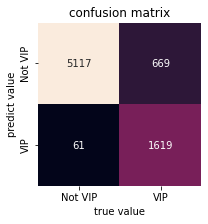

In [ ]:
matric = confusion_matrix(models[0].y_pred, models[0].y_test)
plt.figure(figsize=(3,3))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

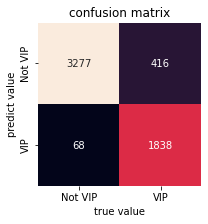

In [ ]:
matric = confusion_matrix(models[1].y_pred, models[1].y_test)
plt.figure(figsize=(3,3))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

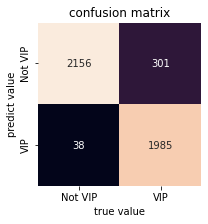

In [ ]:
matric = confusion_matrix(models[2].y_pred, models[2].y_test)
plt.figure(figsize=(3,3))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",models[0].classification_report)

report:
               precision    recall  f1-score   support

    inactive       0.88      0.99      0.93      5178
      active       0.96      0.71      0.82      2288

    accuracy                           0.90      7466
   macro avg       0.92      0.85      0.87      7466
weighted avg       0.91      0.90      0.90      7466



In [ ]:
print("report:\n",models[1].classification_report)

report:
               precision    recall  f1-score   support

    inactive       0.89      0.98      0.93      3345
      active       0.96      0.82      0.88      2254

    accuracy                           0.91      5599
   macro avg       0.93      0.90      0.91      5599
weighted avg       0.92      0.91      0.91      5599



In [ ]:
print("report:\n",models[2].classification_report)

report:
               precision    recall  f1-score   support

    inactive       0.88      0.98      0.93      2194
      active       0.98      0.87      0.92      2286

    accuracy                           0.92      4480
   macro avg       0.93      0.93      0.92      4480
weighted avg       0.93      0.92      0.92      4480



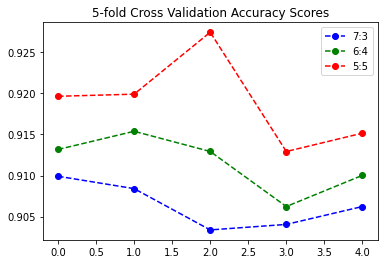

In [ ]:
plt.plot(models[0].cv_score_accuracy['scores'], linestyle='--', marker='o', color='b', label='7:3')
plt.plot(models[1].cv_score_accuracy['scores'], linestyle='--', marker='o', color='g', label='6:4')
plt.plot(models[2].cv_score_accuracy['scores'], linestyle='--', marker='o', color='r', label='5:5')
plt.title('5-fold Cross Validation Accuracy Scores')
plt.legend()

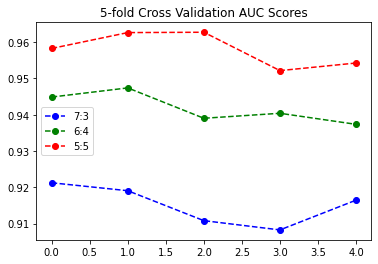

In [ ]:
plt.plot(models[0].cv_score_roc['scores'], linestyle='--', marker='o', color='b', label='7:3')
plt.plot(models[1].cv_score_roc['scores'], linestyle='--', marker='o', color='g', label='6:4')
plt.plot(models[2].cv_score_roc['scores'], linestyle='--', marker='o', color='r', label='5:5')
plt.title('5-fold Cross Validation AUC Scores')
plt.legend()

### Train Binary Model

In [ ]:
counter = Counter(y)

In [ ]:
active_weight = 0.5
inactive_num = int(counter[1]*(1-active_weight)/active_weight)
nm = NearMiss(sampling_strategy={0: inactive_num}, version=1)
X_res, y_res = nm.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y_res)
print('undersampling:', counter)

undersampling: Counter({0: 11198, 1: 11198})


In [ ]:
data_res = pd.concat([X_res, y_res], axis=1)

In [ ]:
data_res.to_csv('Random Forest UnderSampled Data.csv', index=False)

### 訓練 model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=123)

### Hyperparameter Tuning

In [ ]:
# Determine optimal parameters:
# Declare a baseline classifier:
forest = RandomForestClassifier()

# Create the grid parameter:
grid_rf = {
    'n_estimators': [100, 120, 150, 200],
    'criterion': ['entropy', 'gini'], 
    'max_depth': range(2,6),
    'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,11),
    # 'n_estimators': [150],
    # 'criterion': ['gini'],
    # 'max_depth': [5],
    # 'max_features': ['auto'],
    # 'min_samples_split': [2],
    # 'min_samples_leaf': [4]
}

# Create the grid:
gs_rf = GridSearchCV(forest, grid_rf, cv=5, n_jobs=-1, verbose=1)

# Fit using grid search:
gs_rf.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_rf.best_score_)
print('\nBest params:\n', gs_rf.best_params_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 65.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parall

Best accuracy: 0.921

Best params:
 {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
rf_model = RandomForestClassifier(max_depth=5,n_estimators=150,criterion='gini',max_features='auto',min_samples_split=2,min_samples_leaf=4)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
rfc_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

In [ ]:
print("=== All ACCURACY Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean ACCURACY Score ===")
print("Mean ACCURACY Score - Random Forest: ", rfc_cv_score.mean())

=== All ACCURACY Scores ===
[0.91964286 0.92017862 0.92855149 0.91571309 0.91543399]


=== Mean ACCURACY Score ===
Mean ACCURACY Score - Random Forest:  0.9199040110043459


Text(0.5, 1.0, '5-fold Cross Validation Accuracy Scores')

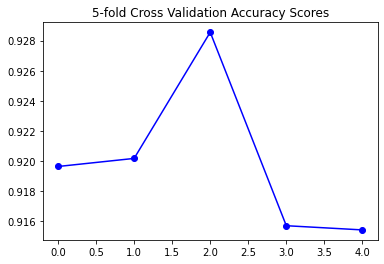

In [ ]:
plt.plot(rfc_cv_score, marker='o', color='b')
plt.title('5-fold Cross Validation Accuracy Scores')

In [ ]:
rfc_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc_ovr')

In [ ]:
print("=== All ROC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean ROC Score ===")
print("Mean ROC Score - Random Forest: ", rfc_cv_score.mean())

=== All ROC Scores ===
[0.95730405 0.96241525 0.96330322 0.95184026 0.95399519]


=== Mean ROC Score ===
Mean ROC Score - Random Forest:  0.9577715941528012


Text(0.5, 1.0, '5-fold Cross Validation AUC Scores')

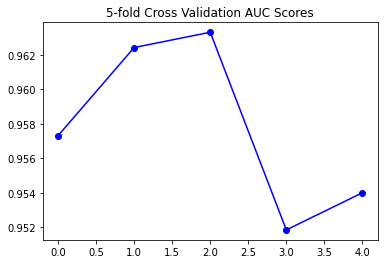

In [ ]:
plt.plot(rfc_cv_score, marker='o', color='b')
plt.title('5-fold Cross Validation AUC Scores')

In [ ]:
print("Accuracy score on train data:", rf_model.score(X_train, y_train))
print("Accuracy score on test data:", rf_model.score(X_test, y_test))
print("F1 score on test data:", f1_score(y_test, y_pred))
print("AUC score on test data:", roc_auc_score(y_test, y_pred))

Accuracy score on train data: 0.9224715338245144
Accuracy score on test data: 0.9241071428571429
F1 score on test data: 0.9209669920966992
AUC score on test data: 0.9253132898041346


In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

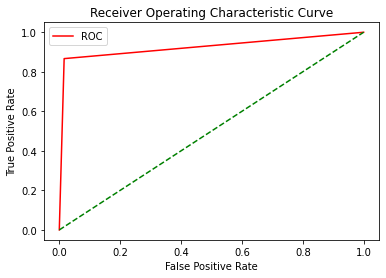

In [ ]:
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fper, tper)

In [ ]:
labels = [0, 1]
label_names = ['Not VIP', 'VIP']

In [ ]:
len(y_test)

4480

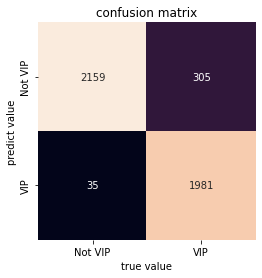

In [ ]:
matric = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_test, y_pred,labels=labels,target_names=label_names))

report:
               precision    recall  f1-score   support

     Not VIP       0.88      0.98      0.93      2194
         VIP       0.98      0.87      0.92      2286

    accuracy                           0.92      4480
   macro avg       0.93      0.93      0.92      4480
weighted avg       0.93      0.92      0.92      4480



In [ ]:
importance = list(rf_model.feature_importances_)
rf_FS = pd.DataFrame({'Columns': list(X_res.columns), 'Importance': importance}).sort_values(by=["Importance"], ascending=False)
rf_FS

,Columns,Importance
7,CompleteOrders,0.341518
5,ActiveDays,0.187161
4,Frequency,0.128183
3,Recency,0.090430
2,Monetary,0.085616
1,CAI,0.077826
0,Lifespan_days,0.076409
8,ReturnRate,0.007226
6,PromotionUsedRate,0.005631


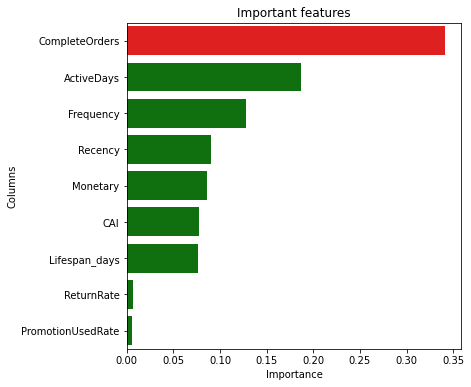

In [ ]:
values = rf_FS.Importance    
idx = rf_FS.Columns
plt.figure(figsize=(6,6))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features')
plt.show()

In [ ]:
fn=X_res.columns
cn=label_names
# plt.figure(figsize=(12,12))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (45,8), dpi=800)
tree.plot_tree(rf_model.estimators_[0], feature_names = fn, class_names=cn, filled = True, rounded=True, fontsize=7, impurity=False);
# fig.savefig('rf_individualtree.png')

In [ ]:
y_pred_all = rf_model.predict(X)

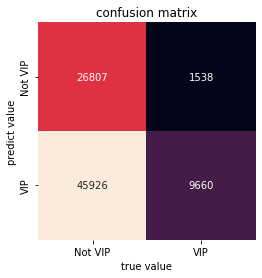

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=labels,target_names=label_names))

report:
               precision    recall  f1-score   support

     Not VIP       0.37      0.95      0.53     28345
         VIP       0.86      0.17      0.29     55586

    accuracy                           0.43     83931
   macro avg       0.62      0.56      0.41     83931
weighted avg       0.70      0.43      0.37     83931



## 輸出訓練及測試資料

In [ ]:
pd.concat([X_test, y_test], axis=1).to_csv('Test Data.csv')

In [ ]:
pd.concat([X_train, y_train], axis=1).to_csv('Train Data.csv')